In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.feature_selection import RFE

In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

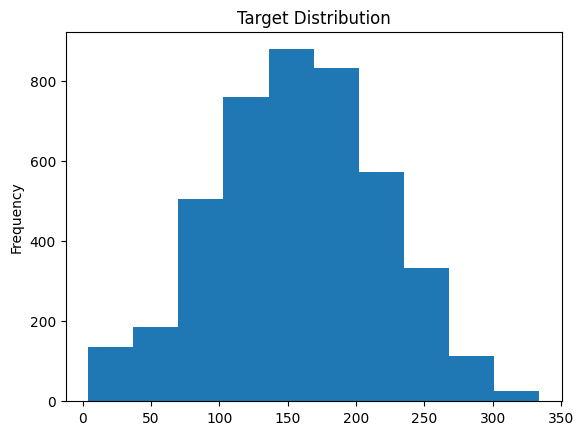

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [13]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [14]:
merged_df.shape

(4343, 184)

In [34]:
# Initialize the model
model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=10000, random_state=42, metric='RMSE')

# Initialize and train a LightGBM model
model.fit(merged_df, y)

# Extract feature importance
lgbm_feature_importances = pd.DataFrame({
    'Feature': merged_df.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Threshold for dropping low-importance features
threshold_lgbm = 0.01

# Keep features above the threshold
lgbm_selected_features = lgbm_feature_importances[lgbm_feature_importances['Importance'] > threshold_lgbm]['Feature']

# Filter the original dataset
merged_df_lgb = merged_df[lgbm_selected_features]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809


In [35]:
len(merged_df_lgb.columns)

181

In [36]:
#The model shall handle missing values and encode categorical columns
model2 = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.01,
    depth=10,
    loss_function='RMSE',  # Default regression loss
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)

model2.fit(merged_df, y)

# Extract feature importance
catboost_feature_importances = pd.DataFrame({
    'Feature': merged_df.columns,
    'Importance': model2.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

# Threshold for dropping low-importance features
threshold_catboost = 0.01

# Keep features above the threshold
catboost_selected_features = catboost_feature_importances[
    catboost_feature_importances['Importance'] > threshold_catboost]['Feature']

# Filter the original dataset
merged_df_cat = merged_df[catboost_selected_features]

0:	learn: 60.6445520	total: 12.7ms	remaining: 2m 6s
100:	learn: 45.0332493	total: 2.65s	remaining: 4m 19s
200:	learn: 38.9044928	total: 5.78s	remaining: 4m 41s
300:	learn: 35.5399273	total: 8.95s	remaining: 4m 48s
400:	learn: 33.3917089	total: 12s	remaining: 4m 48s
500:	learn: 31.8994396	total: 14.8s	remaining: 4m 40s
600:	learn: 30.7114954	total: 17.5s	remaining: 4m 34s
700:	learn: 29.6846195	total: 20.3s	remaining: 4m 29s
800:	learn: 28.8254993	total: 22.9s	remaining: 4m 23s
900:	learn: 27.9642830	total: 25.7s	remaining: 4m 19s
1000:	learn: 27.1063650	total: 28.6s	remaining: 4m 17s
1100:	learn: 26.4289151	total: 31.6s	remaining: 4m 15s
1200:	learn: 25.7500371	total: 34.5s	remaining: 4m 12s
1300:	learn: 25.0498635	total: 37.4s	remaining: 4m 10s
1400:	learn: 24.4402644	total: 40.5s	remaining: 4m 8s
1500:	learn: 23.9600868	total: 43.8s	remaining: 4m 7s
1600:	learn: 23.4730841	total: 47s	remaining: 4m 6s
1700:	learn: 23.0239954	total: 50.3s	remaining: 4m 5s
1800:	learn: 22.5589787	total:

In [37]:
len(merged_df_cat.columns)

182

In [38]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data for LightGBM
    train_lgb_X, val_lgb_X = merged_df_lgb.iloc[train_index], merged_df_lgb.iloc[val_index]
    train_cat_X, val_cat_X = merged_df_cat.iloc[train_index], merged_df_cat.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train LightGBM
    model1 = lgb.LGBMRegressor( # feature_fraction=0.8, bagging_fraction=0.8,
        learning_rate=0.01, n_estimators=1000, random_state=42,
         metric='RMSE'
    )
    model1.fit(train_lgb_X, train_y, eval_set=[(val_lgb_X, val_y)])
    pred1 = model1.predict(val_lgb_X, num_iteration=model1.best_iteration_)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_cat_X, train_y, eval_set=(val_cat_X, val_y))
    pred2 = model2.predict(val_cat_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2 = weights
        combined_predictions = w1 * pred1 + w2 * pred2
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [0.5, 0.5]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = optimized_weights[0] * pred1 + optimized_weights[1] * pred2

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions) # np.mean((final_predictions - val_y) ** 2)
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 181
[LightGBM] [Info] Start training from score 157.136730
0:	learn: 61.1053693	test: 58.8031414	best: 58.8031414 (0)	total: 16.5ms	remaining: 2m 45s
100:	learn: 45.2770416	test: 45.4929423	best: 45.4929423 (100)	total: 2.38s	remaining: 3m 53s
200:	learn: 38.9985713	test: 41.4256895	best: 41.4256895 (200)	total: 5.33s	remaining: 4m 19s
300:	learn: 35.6788887	test: 39.8385194	best: 39.8385194 (300)	total: 8.18s	remaining: 4m 23s
400:	learn: 33.2917862	test: 39.0640395	best: 39.0640395 (400)	total: 10.9s	remaining: 4m 21s
500:	learn: 31.5319436	test: 38.5820304	best: 38.5820304 (500)	total: 13.5s	remaining: 4m 16s
600:	learn: 30.1194891	test: 38

1it [05:20, 320.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1545
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 181
[LightGBM] [Info] Start training from score 157.271445
0:	learn: 59.9814396	test: 63.1840727	best: 63.1840727 (0)	total: 90.1ms	remaining: 15m
100:	learn: 45.0126183	test: 47.3554492	best: 47.3554492 (100)	total: 2.56s	remaining: 4m 10s
200:	learn: 38.9439727	test: 42.2117235	best: 42.2117235 (200)	total: 5.45s	remaining: 4m 25s
300:	learn: 35.4776987	test: 40.1911410	best: 40.1911410 (300)	total: 8.44s	remaining: 4m 32s
400:	learn: 33.1732214	test: 39.0930451	best: 39.0930451 (400)	total: 11.3s	remaining: 4m 29s
500:	learn: 31.6284093	test: 38.5024799	best: 38.5024799 (500)	total: 14.1s	remaining: 4m 27s
600:	learn: 30.2942350	test: 38.13

2it [08:53, 257.59s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 181
[LightGBM] [Info] Start training from score 156.375360
0:	learn: 60.9092508	test: 59.6039096	best: 59.6039096 (0)	total: 16.7ms	remaining: 2m 47s
100:	learn: 45.0724482	test: 46.6337210	best: 46.6337210 (100)	total: 2.35s	remaining: 3m 50s
200:	learn: 38.8923743	test: 42.7293699	best: 42.7293699 (200)	total: 5.12s	remaining: 4m 9s
300:	learn: 35.5250600	test: 41.1850222	best: 41.1850222 (300)	total: 7.92s	remaining: 4m 15s
400:	learn: 33.1208742	test: 40.3532775	best: 40.3532775 (400)	total: 10.6s	remaining: 4m 14s
500:	learn: 31.2974665	test: 39.8508131	best: 39.8508131 (500)	total: 13.3s	remaining: 4m 11s
600:	learn: 30.0665972	test: 39.

3it [13:54, 277.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 181
[LightGBM] [Info] Start training from score 157.237122
0:	learn: 60.6007853	test: 60.7992624	best: 60.7992624 (0)	total: 18.9ms	remaining: 3m 9s
100:	learn: 45.1128686	test: 46.6146113	best: 46.6146113 (100)	total: 2.53s	remaining: 4m 7s
200:	learn: 38.8521874	test: 42.2008683	best: 42.2008683 (200)	total: 5.69s	remaining: 4m 37s
300:	learn: 35.4791462	test: 40.5222654	best: 40.5222654 (300)	total: 8.62s	remaining: 4m 37s
400:	learn: 33.1647211	test: 39.7403511	best: 39.7403511 (400)	total: 11.5s	remaining: 4m 36s
500:	learn: 31.4839516	test: 39.2565931	best: 39.2565931 (500)	total: 14.3s	remaining: 4m 31s
600:	learn: 30.1674068	test: 38.9

4it [18:43, 281.83s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 181
[LightGBM] [Info] Start training from score 157.063309
0:	learn: 60.6047243	test: 60.8093902	best: 60.8093902 (0)	total: 10.1ms	remaining: 1m 40s
100:	learn: 44.5947380	test: 47.5945995	best: 47.5945995 (100)	total: 2.58s	remaining: 4m 13s
200:	learn: 38.4136079	test: 43.9925501	best: 43.9925501 (200)	total: 5.39s	remaining: 4m 22s
300:	learn: 34.9488254	test: 42.6001876	best: 42.6001876 (300)	total: 8.39s	remaining: 4m 30s
400:	learn: 32.6395534	test: 41.9519480	best: 41.9519480 (400)	total: 11.2s	remaining: 4m 27s
500:	learn: 30.9478133	test: 41.5865983	best: 41.5865983 (500)	total: 14s	remaining: 4m 25s
600:	learn: 29.6945931	test: 41.3

5it [22:32, 270.54s/it]

Average MSE across folds: 37.219871995423716
Optimized weights per fold: [array([0.24035229, 0.75964771]), array([0.40595331, 0.59404669]), array([5.54440938e-11, 1.00000000e+00]), array([0.31933437, 0.68066563]), array([0.09808798, 0.90191202])]


In [39]:
np.mean(optimized_weights_list, axis=0)

array([0.21274559, 0.78725441])

In [41]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
final_model1 = lgb.LGBMRegressor(
    learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE' # feature_fraction=0.8, bagging_fraction=0.8,
)
final_model1.fit(merged_df, y)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/LGBMCatBoostV2.4.csv', index=False)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.783320
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.559659
[LightGBM] [Debug] init for col-wise cost 0.001016 seconds, init for row-wise cost 0.009831 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 